# 04_early_warning_demo1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(
    "../data/processed/model/lassa_era5_weekly_panel_2018_2021.csv"
)

df = df.sort_values(["state", "year", "week"]).reset_index(drop=True)

print(df.shape)
df.head()


(7733, 6)


,state,year,week,cases,rain_mm,temp_c
0,Abia,2018,1,0,0.029167,27.110085
1,Abia,2018,2,0,2.389669,28.605963
2,Abia,2018,3,0,2.002001,29.030485
3,Abia,2018,4,0,0.611703,28.548828
4,Abia,2018,5,0,0.249704,30.093192


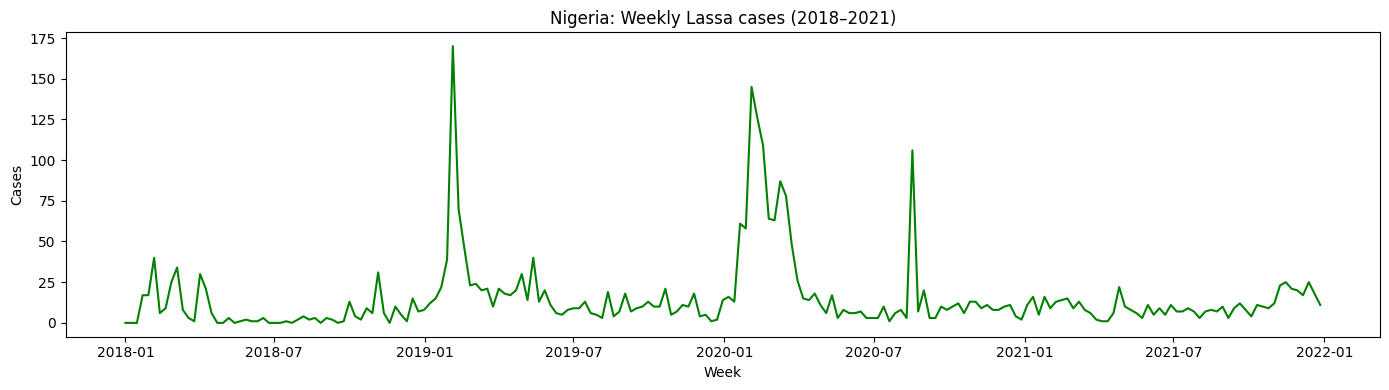

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

df = pd.read_csv("../data/processed/model/lassa_era5_weekly_panel_2018_2021.csv")

# national series
nat = df.groupby(["year","week"], as_index=False).agg(
    cases=("cases","sum"),
    rain_mm=("rain_mm","mean"),
    temp_c=("temp_c","mean"),
).sort_values(["year","week"]).reset_index(drop=True)

# ISO week -> date (Monday of that epi week)
nat["week_start"] = nat.apply(lambda r: date.fromisocalendar(int(r["year"]), int(r["week"]), 1), axis=1)

plt.figure(figsize=(14,4))
plt.plot(nat["week_start"], nat["cases"], color="green")
plt.title("Nigeria: Weekly Lassa cases (2018–2021)")
plt.xlabel("Week")
plt.ylabel("Cases")
plt.tight_layout()
plt.show()


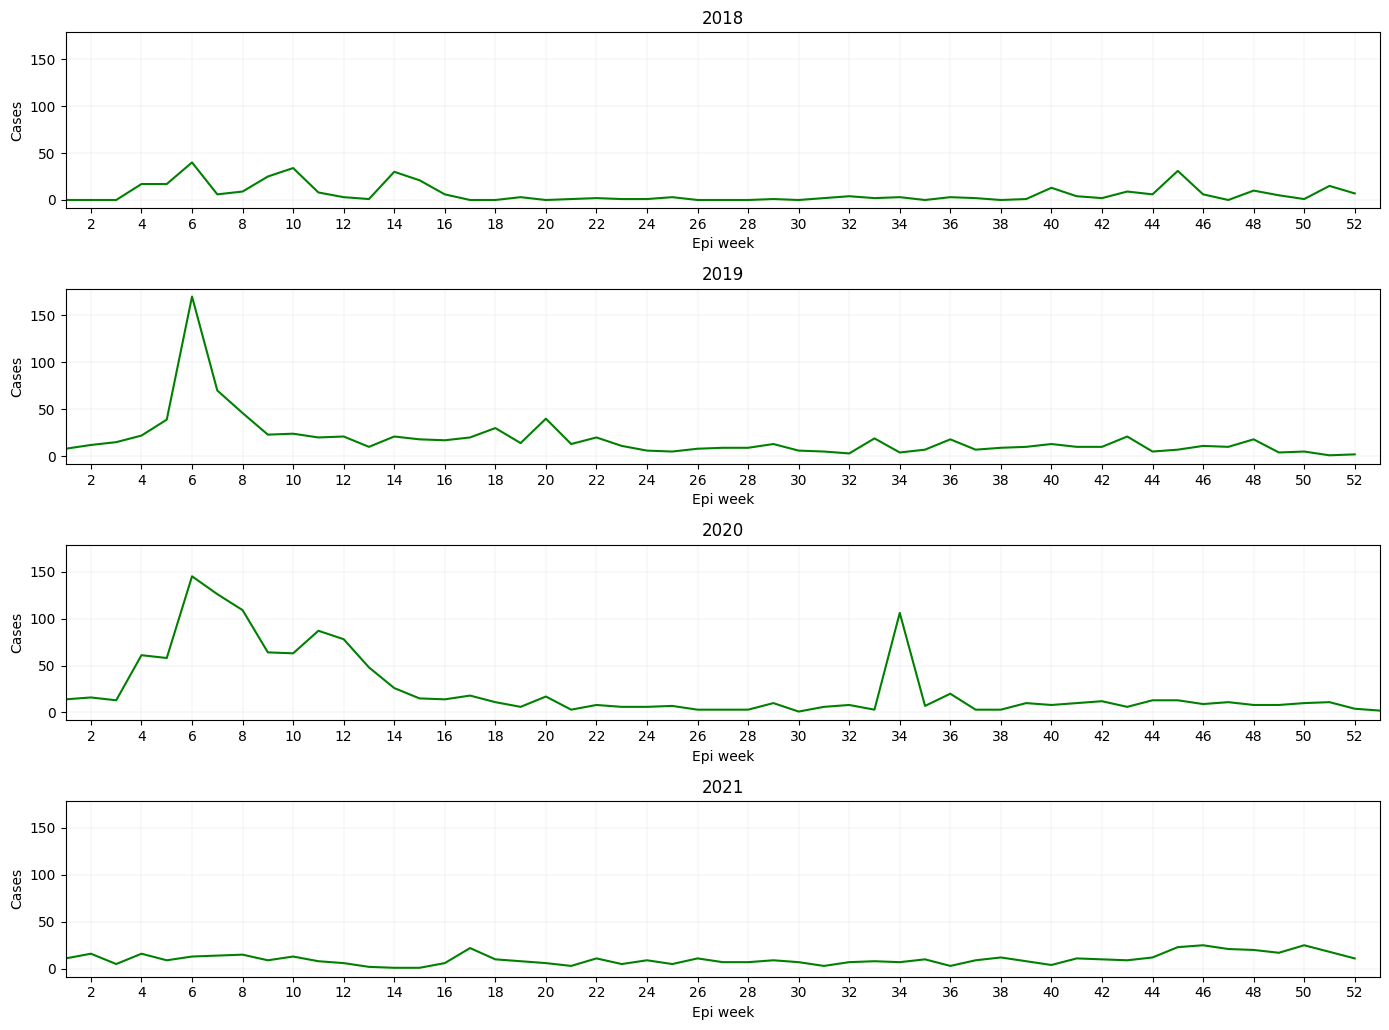

In [30]:
nat = df.groupby(["year","week"], as_index=False).agg(
    cases=("cases","sum"),
    rain_mm=("rain_mm","mean"),
    temp_c=("temp_c","mean"),
).sort_values(["year","week"]).reset_index(drop=True)

years = sorted(nat["year"].unique())

fig, axes = plt.subplots(len(years), 1, figsize=(14, 2.6*len(years)), sharey=True)

if len(years) == 1:
    axes = [axes]

for ax, y in zip(axes, years):
    sub = nat[nat["year"] == y]
    ax.plot(sub["week"], sub["cases"], color="green")
    ax.set_title(f"{y}")
    ax.set_xlim(1, 53)
    ax.set_xticks(list(range(2, 53, 2)))  # 2,4,6,...
    ax.set_xlabel("Epi week")
    ax.set_ylabel("Cases")
    ax.grid(True, linewidth=0.3, alpha=0.4)

plt.tight_layout()
plt.show()

In [31]:
# Normalise climate variables
df["rain_z"] = (df["rain_mm"] - df["rain_mm"].mean()) / df["rain_mm"].std()
df["temp_z"] = (df["temp_c"] - df["temp_c"].mean()) / df["temp_c"].std()

# Rodent pressure proxy
df["rodent_pressure"] = (
    0.6 * df["rain_z"] + 0.4 * df["temp_z"]
)

df[["rain_mm", "temp_c", "rodent_pressure"]].describe()


,rain_mm,temp_c,rodent_pressure
count,7733.000000,7733.000000,7.733000e+03
mean,26.069092,27.130784,-1.690675e-16
std,30.978627,2.337570,5.866794e-01
min,0.000000,17.212690,-2.202075e+00
25%,0.437433,25.648926,-3.246096e-01
50%,14.593513,26.967558,-1.223731e-02
75%,43.055013,28.288890,3.232048e-01
max,217.977789,35.633318,3.407604e+00


In [32]:
def seir_step(
    Sh, Eh, Ih, Rh,
    Sr, Er, Ir,
    beta_hr,   # rodent → human
    beta_rr,   # rodent → rodent
    sigma_h, gamma_h,
    sigma_r, gamma_r
):
    # New infections
    new_Eh = beta_hr * Sh * Ir
    new_Er = beta_rr * Sr * Ir

    # Human transitions
    new_Ih = sigma_h * Eh
    new_Rh = gamma_h * Ih

    # Rodent transitions
    new_Ir = sigma_r * Er
    new_Rr = gamma_r * Ir

    # Update
    Sh -= new_Eh
    Eh += new_Eh - new_Ih
    Ih += new_Ih - new_Rh
    Rh += new_Rh

    Sr -= new_Er
    Er += new_Er - new_Ir
    Ir += new_Ir - new_Rr

    return Sh, Eh, Ih, Rh, Sr, Er, Ir


In [5]:
def beta_hr_from_climate(rpi, base=0.002):
    return base * np.exp(rpi)


In [16]:
weeks = df[(df.year == 2021)].sort_values("week")

# Initial states (scaled, not absolute)
Sh, Eh, Ih, Rh = 0.99, 0.005, 0.005, 0.0
Sr, Er, Ir = 0.9, 0.05, 0.05

trajectory = []

for _, row in weeks.iterrows():
    beta_hr = beta_hr_from_climate(row["rodent_pressure"])

    Sh, Eh, Ih, Rh, Sr, Er, Ir = seir_step(
        Sh, Eh, Ih, Rh,
        Sr, Er, Ir,
        beta_hr=beta_hr,
        beta_rr=0.01,
        sigma_h=0.3, gamma_h=0.2,
        sigma_r=0.4, gamma_r=0.3
    )

    trajectory.append(Ih)

weeks["Ih_sim"] = trajectory


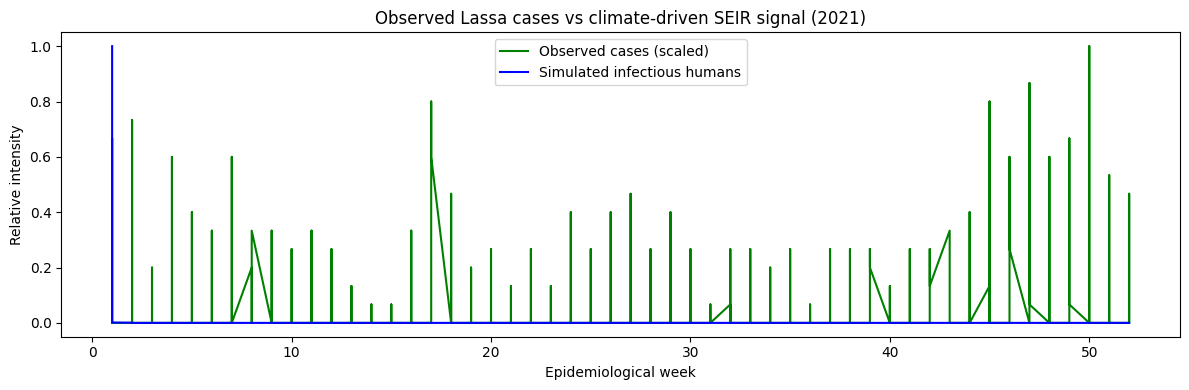

In [28]:
plt.figure(figsize=(12,4))
plt.plot(weeks["week"], weeks["cases"] / weeks["cases"].max(),
         label="Observed cases (scaled)", color="green")
plt.plot(weeks["week"], weeks["Ih_sim"] / max(weeks["Ih_sim"]),
         label="Simulated infectious humans", color="blue")

plt.xlabel("Epidemiological week")
plt.ylabel("Relative intensity")
plt.title("Observed Lassa cases vs climate-driven SEIR signal (2021)")
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
scenarios = {
    "baseline": 0.0,
    "wetter": 0.5,
    "hotter": 0.5,
    "hot_wet": 1.0
}

scenario_outputs = {}

for name, shock in scenarios.items():
    Ih = 0.005
    Ih_path = []

    for rpi in weeks["rodent_pressure"]:
        beta_hr = beta_hr_from_climate(rpi + shock)
        Ih = Ih + beta_hr * (1 - Ih) - 0.2 * Ih
        Ih_path.append(Ih)

    scenario_outputs[name] = Ih_path


TypeError: unhashable type: 'dict'

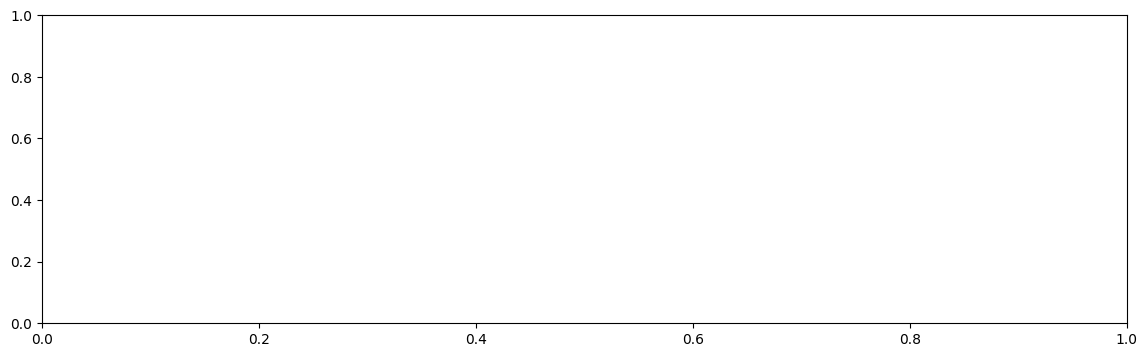

In [45]:
import numpy as np
import matplotlib.pyplot as plt

T = len(scenario_outputs)  # your simulated series length in weeks
x = np.arange(T)

plt.figure(figsize=(14,4))
plt.plot(x, scenario_outputs, label="baseline")

# year ticks every 52 weeks
tick_pos = np.arange(0, T+1, 52)
tick_lab = [f"Y{1+i}" for i in range(len(tick_pos))]
plt.xticks(tick_pos, tick_lab)

plt.xlabel("Years (52-week blocks)")
plt.ylabel("Relative infection pressure")
plt.title("Projected Lassa risk under climate scenarios (proxy)")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'I' is not defined